In [37]:
! pip install --upgrade imgaug

In [46]:
#Importation des modules
import numpy as np
import pandas as pd

# import basic libraries
import os
from glob import glob

# import plotting
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns

# import image manipulation
from PIL import Image
import imageio


In [47]:
# import data augmentation
import imgaug as ia
from imgaug import augmenters as iaa

# import segmentation maps from imgaug
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import imgaug.imgaug

In [152]:
# Définition des paths pour accéder aux sets d'entrainement et de test
TRAIN_PATH = 'F:\\Travail\\DataScientest\\understanding_cloud_organization\\train_images\\'
TEST_PATH = 'F:\\Travail\\DataScientest\\understanding_cloud_organization\\test_images\\'

slash = '\\' if os.name == 'nt' else '/'

In [49]:
# Chargement du jeu de données d'entrainement
train_df = pd.read_csv('F:\\Travail\\DataScientest\\understanding_cloud_organization\\train.csv')

# Chargement des noms de fichiers pour le jeu d'entrainment
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))

print('Il y a {} images dans le jeu d\'entrainement.'.format(len(train_fns)))

Il y a 5546 images dans le jeu d'entrainement.


In [50]:
# Chargement des fichiers iùmages de test
test_fns = sorted(glob(TEST_PATH + '*.jpg'))

print('Il y a {} images dans le jeu d\'entrainement.'.format(len(test_fns)))

Il y a 3698 images dans le jeu d'entrainement.


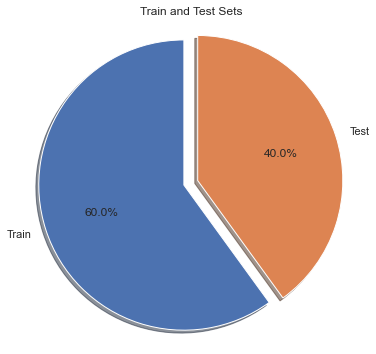

In [51]:
# Affichage d'un camembert pour montrer la répartition des données entre jeu d'entrainement et jeu de test 
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Train and Test Sets')

plt.show()

In [52]:
# Recherche des données nulles dans le DataFrame d'entraînement
print('Il y a  {} lignes avec des cartes de segmentation vides.'.format(len(train_df) - train_df.EncodedPixels.count()))

Il y a  10348 lignes avec des cartes de segmentation vides.


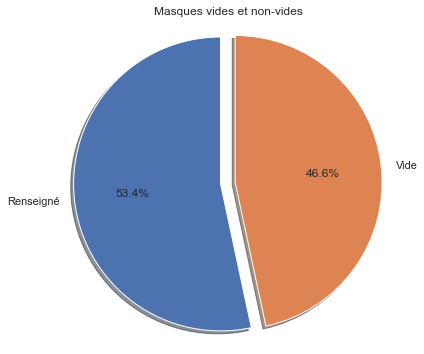

In [53]:
# Représentation dans un camembert de la proportion de masques vides
labels = 'Renseigné', 'Vide'
sizes = [train_df.EncodedPixels.count(), len(train_df) - train_df.EncodedPixels.count()]
explode = (0, 0.1)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Masques vides et non-vides')

plt.show()

In [107]:
# Exploration des labels:
# Ajout d'une colonne 'Image' et d'une colonne 'Label' à train_df par découpage de la colonne 'Image_label'
split_df = train_df["Image_Label"].str.split("_", n = 1, expand = True)
train_df['Image'] = split_df[0]
train_df['Label'] = split_df[1]

# Affichage des premières lignes du DataFrame
train_df.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image   Label  
0  0011165.jpg    Fish  
1  0011165.jpg  Flower  
2  0011165.jpg  Gravel  
3  0011165.jpg   Sugar  
4  002be4f.jpg    Fish

In [111]:
fish = train_df[train_df['Label'] == 'Fish'].EncodedPixels.count()
flower = train_df[train_df['Label'] == 'Flower'].EncodedPixels.count()
gravel = train_df[train_df['Label'] == 'Gravel'].EncodedPixels.count()
sugar = train_df[train_df['Label'] == 'Sugar'].EncodedPixels.count()

print('Il y a {} nuages "fish"'.format(fish))
print('Il y a {} nuages "flower"'.format(flower))
print('Il y a {} nuages "gravel"'.format(gravel))
print('Il y a {} nuages "sugar"'.format(sugar))

Il y a 2781 nuages "fish"
Il y a 2365 nuages "flower"
Il y a 2939 nuages "gravel"
Il y a 3751 nuages "sugar"


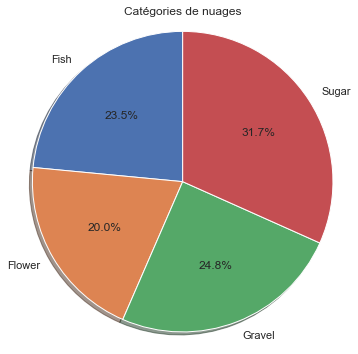

In [112]:
# Fréquence des nuages suivant leur typologie
labels = 'Fish', 'Flower', 'Gravel', 'Sugar'
sizes = [fish, flower, gravel, sugar]

fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
ax.set_title('Catégories de nuages')

plt.show()

Exploration du nombre moyen de labels par image

In [113]:
labels_per_image = train_df.groupby('Image')['EncodedPixels'].count()
print('Le nombre moyen de labels par image est de {}'.format(labels_per_image.mean()))

Le nombre moyen de labels par image est de 2.134150739271547


Répartition des labels par image

Text(0.5, 1.0, 'Number of Labels per Image')

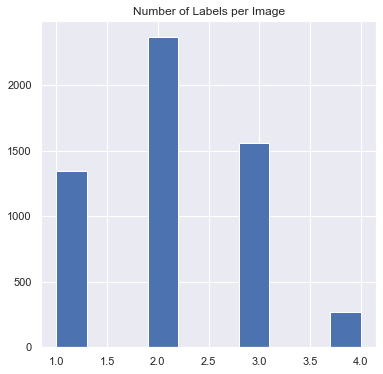

In [114]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(labels_per_image)
ax.set_title('Number of Labels per Image')

Exploration des corrélations entre différents types de nuages

In [118]:
# create dummy columns for each cloud type
corr_df = pd.get_dummies(train_df, columns = ['Label'])
# fill null values with '-1'
corr_df = corr_df.fillna('-1')

# define a helper function to fill dummy columns
def get_dummy_value(row, cloud_type):
    ''' Get value for dummy column '''
    if cloud_type == 'fish':
        return row['Label_Fish'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'flower':
        return row['Label_Flower'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'gravel':
        return row['Label_Gravel'] * (row['EncodedPixels'] != '-1')
    if cloud_type == 'sugar':
        return row['Label_Sugar'] * (row['EncodedPixels'] != '-1')
    
# fill dummy columns
corr_df['Label_Fish'] = corr_df.apply(lambda row: get_dummy_value(row, 'fish'), axis=1)
corr_df['Label_Flower'] = corr_df.apply(lambda row: get_dummy_value(row, 'flower'), axis=1)
corr_df['Label_Gravel'] = corr_df.apply(lambda row: get_dummy_value(row, 'gravel'), axis=1)
corr_df['Label_Sugar'] = corr_df.apply(lambda row: get_dummy_value(row, 'sugar'), axis=1)

# check the result
corr_df.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                 -1   
3   0011165.jpg_Sugar                                                 -1   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image  Label_Fish  Label_Flower  Label_Gravel  Label_Sugar  
0  0011165.jpg           1             0             0            0  
1  0011165.jpg           0             1             0            0  
2  0011165.jpg           0             0             0            0  
3  0011165.jpg           0             0             0            0  
4  002be4f.jpg           1             0             0            0

In [119]:
# group by the image
corr_df = corr_df.groupby('Image')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()
corr_df.head()

<ipython-input-119-b49145703631>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corr_df = corr_df.groupby('Image')['Label_Fish', 'Label_Flower', 'Label_Gravel', 'Label_Sugar'].max()


Label_Fish  Label_Flower  Label_Gravel  Label_Sugar
Image                                                           
0011165.jpg           1             1             0            0
002be4f.jpg           1             1             0            1
0031ae9.jpg           1             1             0            1
0035239.jpg           0             1             1            0
003994e.jpg           1             0             1            1

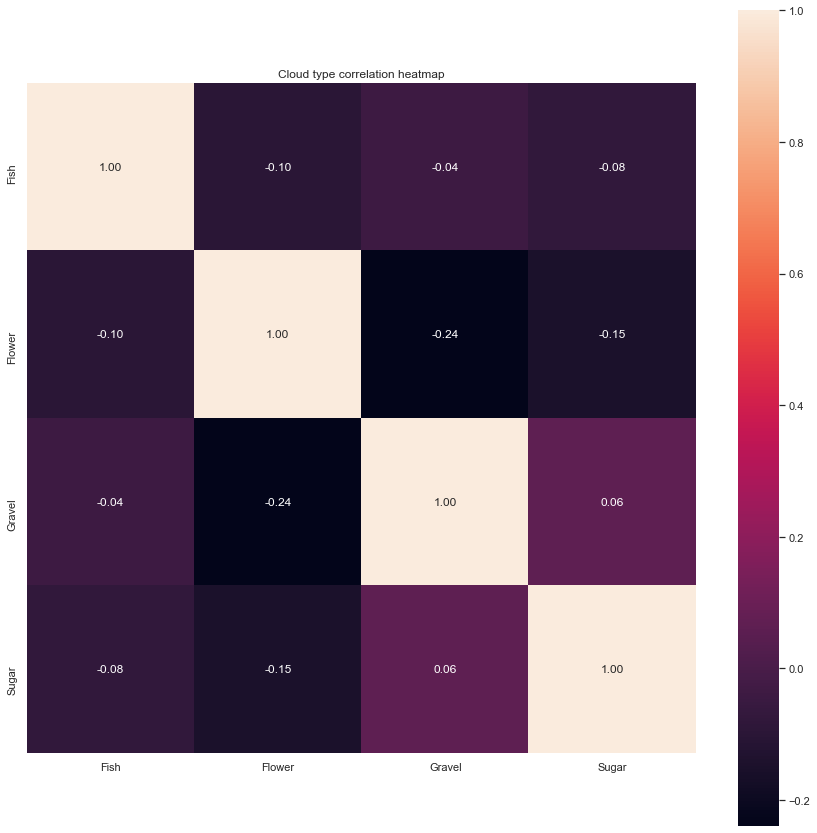

In [120]:
#Find out correlation between columns and plot
corrs = np.corrcoef(corr_df.values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(15,15)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar'], 
            xticklabels = ['Fish', 'Flower', 'Gravel', 'Sugar']).set_title('Cloud type correlation heatmap')

fig = hm.get_figure()

Il n'y a pas de corrélation forte entre les différents types de nuages.
Plus forte corrélation = 24%, entre les nuages de type 'Gravel' et les nuages de type 'Flower'.

Exploration des images:

In [121]:
def get_image_sizes(train = True):
    '''
    Récupère la taille des images des jeux de test et d'entrainement.
    INPUT:
        train - détaille si nous récupérons les tailles des images depuis le jeu de test ou d'entrainement
    '''
    if train == True:
        path = TRAIN_PATH
    else:
        path = TEST_PATH
        
    widths = []
    heights = []
    
    images = sorted(glob(path + '*.jpg'))
    
    max_im = Image.open(images[0])
    min_im = Image.open(images[0])
        
    for im in range(0, len(images)):
        image = Image.open(images[im])
        width, height = image.size
        
        if len(widths) > 0:
            if width > max(widths):
                max_im = image

            if width < min(widths):
                min_im = image

        widths.append(width)
        heights.append(height)
        
    return widths, heights, max_im, min_im

In [122]:
# get sizes of images from test and train sets
train_widths, train_heights, max_train, min_train = get_image_sizes(train = True)
test_widths, test_heights, max_test, min_test = get_image_sizes(train = False)

print('Maximum width for training set is {}'.format(max(train_widths)))
print('Minimum width for training set is {}'.format(min(train_widths)))
print('Maximum height for training set is {}'.format(max(train_heights)))
print('Minimum height for training set is {}'.format(min(train_heights)))

Maximum width for training set is 2100
Minimum width for training set is 2100
Maximum height for training set is 1400
Minimum height for training set is 1400


In [123]:
print('Maximum width for test set is {}'.format(max(test_widths)))
print('Minimum width for test set is {}'.format(min(test_widths)))
print('Maximum height for test set is {}'.format(max(test_heights)))
print('Minimum height for test set is {}'.format(min(test_heights)))

Maximum width for test set is 2100
Minimum width for test set is 2100
Maximum height for test set is 1400
Minimum height for test set is 1400


Affichage d'images depuis le jeu d'entrainement:

In [153]:
# Fonction pour récupérer les labels des images sous fromes de chaines de caractères
def get_labels(image_id):
    ''' Function to get the labels for the image by name'''
    im_df = train_df[train_df['Image'] == image_id].fillna('-1')
    im_df = im_df[im_df['EncodedPixels'] != '-1'].groupby('Label').count()
    
    index = im_df.index
    all_labels = ['Fish', 'Flower', 'Gravel', 'Sugar']
    
    labels = ''
    
    for label in all_labels:
        if label in index:
            labels = labels + ' ' + label
    
    return labels

# Fonction pour afficher une grille d'images et leurs labels
def plot_training_images(width = 5, height = 2):
    """
    Fonction pour afficher la grille avec plusieurs exemples d'images de nuages depuis le jeu d'entrainement.
    Valeurs en entrée:
        width - Nombre d'images par ligne
        height - Nombre de lignes

    Valeurs en sortie: Aucune
    """
    
    # Récupère une liste d'images depuis le jeu d'entrainement
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(width * 3, height * 3))
    
    # Genère une liste aléatoire d'indices
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # Ouvre aléatoirement une image dans la liste
        image = Image.open(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # Affiche l'image
        axs[i,j].imshow(image) # Affiche les données
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split(slash)[-1]))

    # Crée le suptitle
    plt.suptitle('Echantillon d\'images du jeu d\'entrainement')
    plt.show()

On peut maintenant afficher les images

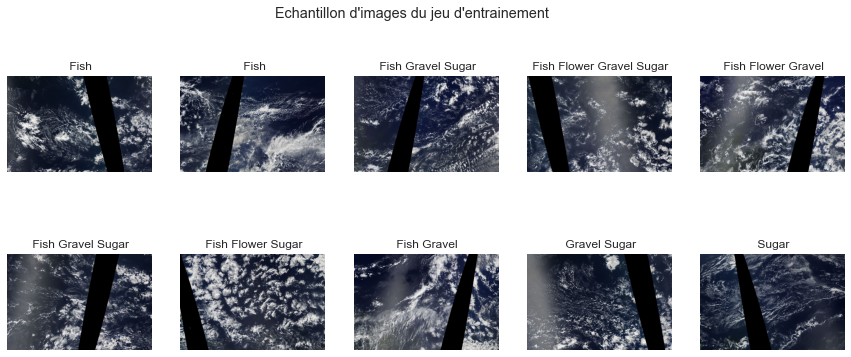

In [154]:
plot_training_images()

Visualisation des cartes de segmentation:

In [129]:
def rle_to_mask(rle_string, width, height):
    '''
    Convertit une chaine RLE(run length encoding) en un tableau numpy

    Valeurs en entrée: 
    rle_string (str): string of rle encoded mask
    height (int): Hauteur du masque
    width (int): Largeur du masque

    Valeur retournées: 
    numpy.array: tableau numpy pour le masque
    '''
    
    rows, cols = height, width
    
    if rle_string == -1:
        return np.zeros((height, width))
    else:
        rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1,2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index, length in rle_pairs:
            index -= 1
            img[index:index+length] = 255
        img = img.reshape(cols,rows)
        img = img.T
        return img

La visualisation des cartes de segmentation se fait avec la librairie imgaug.
Cette librairie dispose de fonctions dédiées à la visualisation d'images et à leur augmentation par des cartes de segmentation.

In [68]:
from __future__ import print_function
import numpy as np

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('La "donnée" a 3 dimensions mais la dernière dimension '
                  'doit avoir une longueur de 3 (RGB) ou 4 (RGBA), et pas "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('Pour visualiser uen image, la donnée doit être 2D ou '
              '3D, et non "{}".'
              ''.format(data.ndim))
        return False

In [158]:
def get_mask(line_id, shape = (2100, 1400)):
    '''
    Fonction pour visualiser l'image et le masque.
    Valeurs en entrée:
        line_id - id of the line to visualize the masks
        shape - image shape
    Valeurs retournées:
        np_mask - Carte de segmentation numpy
    '''
    # Remplacce toutes les valeurs nulles par '-1'
    im_df = train_df.fillna('-1')
    
    # convert rle to mask
    rle = im_df.loc[line_id]['EncodedPixels']
    if rle != '-1':
        np_mask = rle_to_mask(rle, shape[0], shape[1])
        np_mask = np.clip(np_mask, 0, 1)
    else:
        # empty mask
        np_mask = np.zeros((shape[0],shape[1]), dtype=np.uint8)
        
    return np_mask

# Fonction pour obtenir la carte de segmentation d'une image identifiée par son fichier
def get_mask_by_image_id(image_id, label):
    '''
    Fonction pour visualiser plusieurs cartes de segmentation.
    Valeurs en entrée:
        image_id - Nom du fichier image
    Valeurs retournées:
        np_mask - Carte de segmentation numpy
    '''
    im_df = train_df[train_df['Image'] == image_id.split(slash)[-1]].fillna('-1')

    image = np.asarray(Image.open(image_id))

    rle = im_df[im_df['Label'] == label]['EncodedPixels'].values[0]
    if rle != '-1':
        np_mask = rle_to_mask(rle, np.asarray(image).shape[1], np.asarray(image).shape[0])
        np_mask = np.clip(np_mask, 0, 1)
    else:
        # Masque vide
        np_mask = np.zeros((np.asarray(image).shape[0], np.asarray(image).shape[1]), dtype=np.uint8)
        
    return np_mask

def visualize_image_with_mask(line_id):
    '''
    Fonction de visualisation de l'image et du masque.
    Valeurs en entrée:
        line_id - id of the line to visualize the masks
    '''
    # Les valeurs nulles sont remplacées par '-1'
    im_df = train_df.fillna('-1')
    
    # Récupère le masque de segmentation
    np_mask = get_mask(line_id)
    
    # Ouvre l'image
    image = Image.open(TRAIN_PATH + im_df.loc[line_id]['Image'])

    # Crée la carte de segmentation
    segmap = SegmentationMapOnImage(np_mask, np_mask.shape, nb_classes=2)
    
    # Visualise l'image et la carte
    side_by_side = np.hstack([
        segmap.draw_on_image(np.asarray(image))
    ]).reshape(np.asarray(image).shape)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.axis('off')
    plt.title(im_df.loc[line_id]['Label'])
    
    ax.imshow(side_by_side)

Visualisation  des masques sur l'échantillon

C:\Users\Olivier\anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SegmentationMapOnImage()` is deprecated. Use `SegmentationMapsOnImage` instead. (Note the plural 'Maps' instead of old 'Map'.).
  warn_deprecated(msg, stacklevel=3)
C:\Users\Olivier\anaconda3\lib\site-packages\imgaug\imgaug.py:106: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


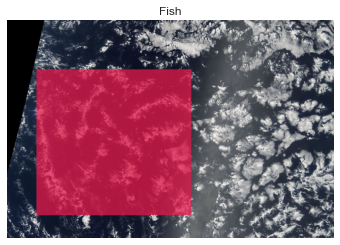

In [70]:
visualize_image_with_mask(0)

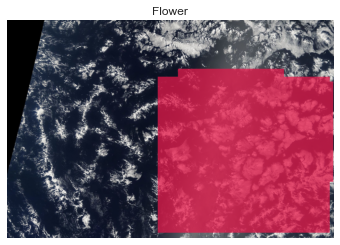

In [71]:
visualize_image_with_mask(1)

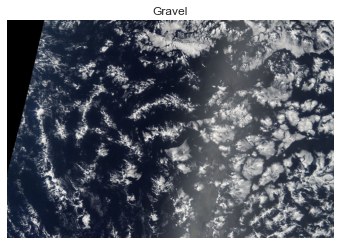

In [72]:
# empty mask:
visualize_image_with_mask(2)

Visualisation d'une grille d'images:

In [140]:
def plot_training_images_and_masks(n_images = 3):
    '''
    Fonction pour afficher aléatoirement plusieurs images avec leurs masques de segmentation.
    Valeurs en entrée:
        n_images - Nombre d'images à visualiser
    '''
    
    # Récupère un eliste d'image depuis le jeu d'entrainement
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, ax = plt.subplots(n_images, 4, figsize=(20, 10))
    
    # Génère iun liste aléatoire d'indices
    rnd_indices = [np.random.choice(range(0, len(images))) for i in range(n_images)]

    
    for im in range(0, n_images):
        # Ouvre une image avec un  index aléatoire
        image = Image.open(images[rnd_indices[im]])
        
        # Récupère les masques de segmentation
        fish = get_mask_by_image_id(images[rnd_indices[im]], 'Fish')
        flower = get_mask_by_image_id(images[rnd_indices[im]], 'Flower')
        gravel = get_mask_by_image_id(images[rnd_indices[im]], 'Gravel')
        sugar = get_mask_by_image_id(images[rnd_indices[im]], 'Sugar')
        
        # Dessine les masques sur les images
        shape = (np.asarray(image).shape[0], np.asarray(image).shape[1])
        if np.sum(fish) > 0:
            segmap_fish = SegmentationMapOnImage(fish, shape=shape, nb_classes=2)
            im_fish = np.array(segmap_fish.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_fish = np.asarray(image)
        
        if np.sum(flower) > 0:
            segmap_flower = SegmentationMapOnImage(flower, shape=shape, nb_classes=2)
            im_flower = np.array(segmap_flower.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_flower = np.asarray(image)
        
        if np.sum(gravel) > 0:
            segmap_gravel = SegmentationMapOnImage(gravel, shape=shape, nb_classes=2)
            im_gravel = np.array(segmap_gravel.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_gravel = np.asarray(image)
        
        if np.sum(sugar) > 0:
            segmap_sugar = SegmentationMapOnImage(sugar, shape=shape, nb_classes=2)
            im_sugar = np.array(segmap_sugar.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
        else:
            im_sugar = np.asarray(image)
        
        # Affiche les images et les masques
        ax[im, 0].imshow(im_fish)
        ax[im, 0].axis('off')
        ax[im, 0].set_title('Fish')
        
        # Affiche les images et les masques
        ax[im, 1].imshow(im_flower)
        ax[im, 1].axis('off')
        ax[im, 1].set_title('Flower')
        
        # Affiche les images et les masques
        ax[im, 2].imshow(im_gravel)
        ax[im, 2].axis('off')
        ax[im, 2].set_title('Gravel')
        
        # Affiche les images et les masques
        ax[im, 3].imshow(im_sugar)
        ax[im, 3].axis('off')
        ax[im, 3].set_title('Sugar')
        
    plt.suptitle('Echantillon d\'images issues du jeu d\'entrainement')
    plt.show()

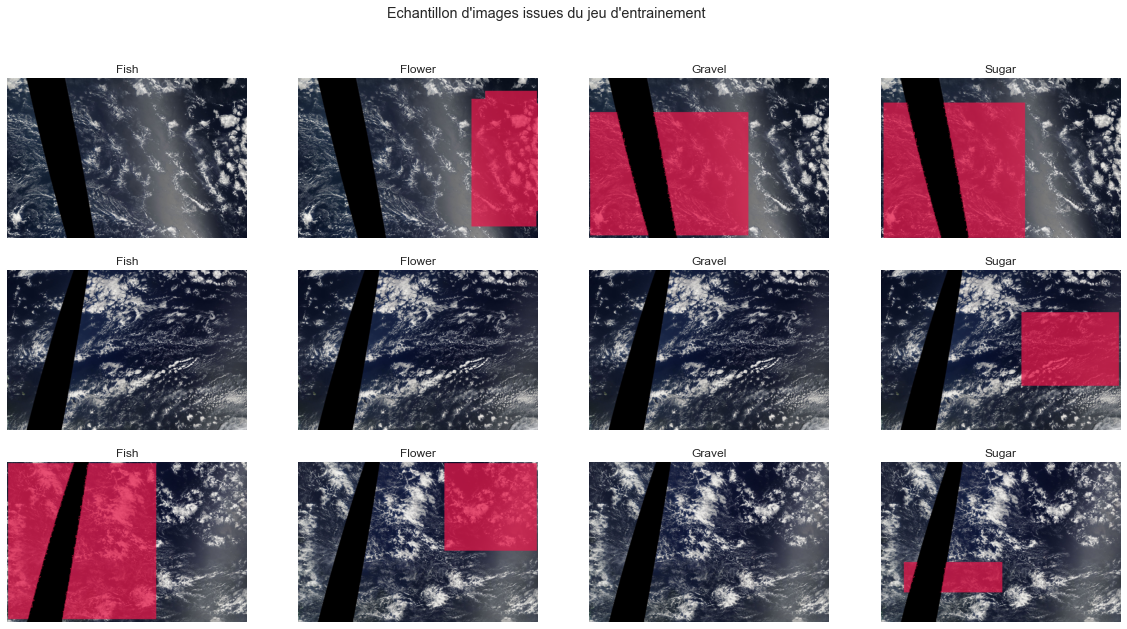

In [159]:
plot_training_images_and_masks(n_images = 3)

In [160]:
def create_segmap(image_id):
    '''
    Helper function to create a segmentation map for an image by image filename
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # get masks for different classes
    fish_mask = get_mask_by_image_id(image_id, 'Fish')
    flower_mask = get_mask_by_image_id(image_id, 'Flower')
    gravel_mask = get_mask_by_image_id(image_id, 'Gravel')
    sugar_mask = get_mask_by_image_id(image_id, 'Sugar')
    
    # label numpy map with 4 classes
    segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    segmap = np.where(fish_mask == 1, 1, segmap)
    segmap = np.where(flower_mask == 1, 2, segmap)
    segmap = np.where(gravel_mask == 1, 3, segmap)
    segmap = np.where(sugar_mask == 1, 4, segmap)
    
    # create a segmantation map
    segmap = SegmentationMapOnImage(segmap, shape=image.shape, nb_classes=5)
    
    return segmap

def draw_labels(image, np_mask, label):
    '''
    Function to add labels to the image.
    '''
    if np.sum(np_mask) > 0:
        x,y = 0,0
        x,y = np.argwhere(np_mask==1)[0]
                
        image = imgaug.imgaug.draw_text(image, x, y, label, color=(255, 255, 255), size=50)
    return image

def draw_segmentation_maps(image_id):
    '''
    Helper function to draw segmantation maps and text.
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # get masks for different classes
    fish_mask = get_mask_by_image_id(image_id, 'Fish')
    flower_mask = get_mask_by_image_id(image_id, 'Flower')
    gravel_mask = get_mask_by_image_id(image_id, 'Gravel')
    sugar_mask = get_mask_by_image_id(image_id, 'Sugar')
    
    # label numpy map with 4 classes
    segmap = create_segmap(image_id)
    
    # draw the map on image
    image = np.asarray(segmap.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
    
    image = draw_labels(image, fish_mask, 'Fish')
    image = draw_labels(image, flower_mask, 'Flower')
    image = draw_labels(image, gravel_mask, 'Gravel')
    image = draw_labels(image, sugar_mask, 'Sugar')
    
    return image

# helper function to visualize several segmentation maps on a single image
def visualize_several_maps(image_id):
    '''
    Function to visualize several segmentation maps.
    INPUT:
        image_id - filename of the image
    '''
    # open the image
    image = np.asarray(Image.open(image_id))
    
    # draw segmentation maps and labels on image
    image = draw_segmentation_maps(image_id)
    
    # visualize the image and map
    side_by_side = np.hstack([
        image
    ])
    
    labels = get_labels(image_id.split(slash)[-1])

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.axis('off')
    plt.title('Segmentation maps:' + labels)
    plt.legend()
    
    ax.imshow(side_by_side)

No handles with labels found to put in legend.


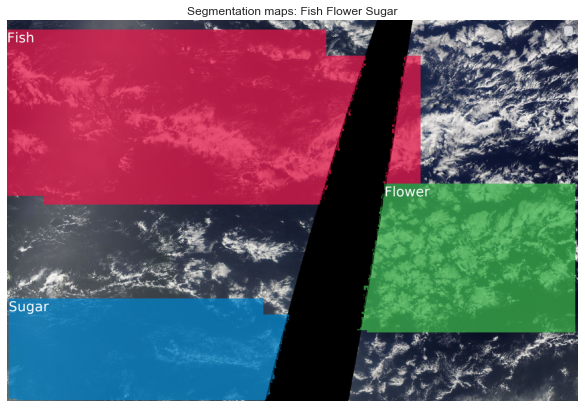

In [161]:
# create list of all training images filenames
train_fns = sorted(glob(TRAIN_PATH + '*.jpg'))

# generate random index for an image
np.random.seed(41)
rnd_index = np.random.choice(range(len(train_fns)))

# call helper function to visualize the image
visualize_several_maps(train_fns[rnd_index])


Il est maintenant possible de mettre en place une fonction pour l'affichage des images sélectionnées, avec les cartes de segmentation

In [166]:
# Fonction d'affichage d'une grille d'images, avec labels et cartes de segmentation
def plot_training_images_and_masks(width = 2, height = 3):
    """
    Fonction our afficher une grille avec plusieurs exemples d'images de nuages du jeu d'entrainement.
    Vraiables en entrée:
        width - Nombre d'images sur chaque ligne
        height - Nmbre de lignes

    Variables retournées: Aucune
    """
    
    # Liste d'images du jeu d'entrainement
    images = sorted(glob(TRAIN_PATH + '*.jpg'))
    
    fig, axs = plt.subplots(height, width, figsize=(20, 20))
    
    # Crée un eliste aléatoire d'indices
    rnd_indices = rnd_indices = [np.random.choice(range(0, len(images))) for i in range(height * width)]
    
    for im in range(0, height * width):
        # Ouvre une image aléatoiremnt désignée par son indice
        image = Image.open(images[rnd_indices[im]])
        # Dessine les cartes de segmentation et les labels sur l'image
        image = draw_segmentation_maps(images[rnd_indices[im]])
        
        i = im // width
        j = im % width
        
        # Affiche l'image
        axs[i,j].imshow(image) #Affiche le sdata
        axs[i,j].axis('off')
        axs[i,j].set_title(get_labels(images[rnd_indices[im]].split(slash)[-1]))

    # set suptitle
    plt.suptitle('Echantillonnage d\'images tirées du jeu d\'entrainement')
    plt.show()

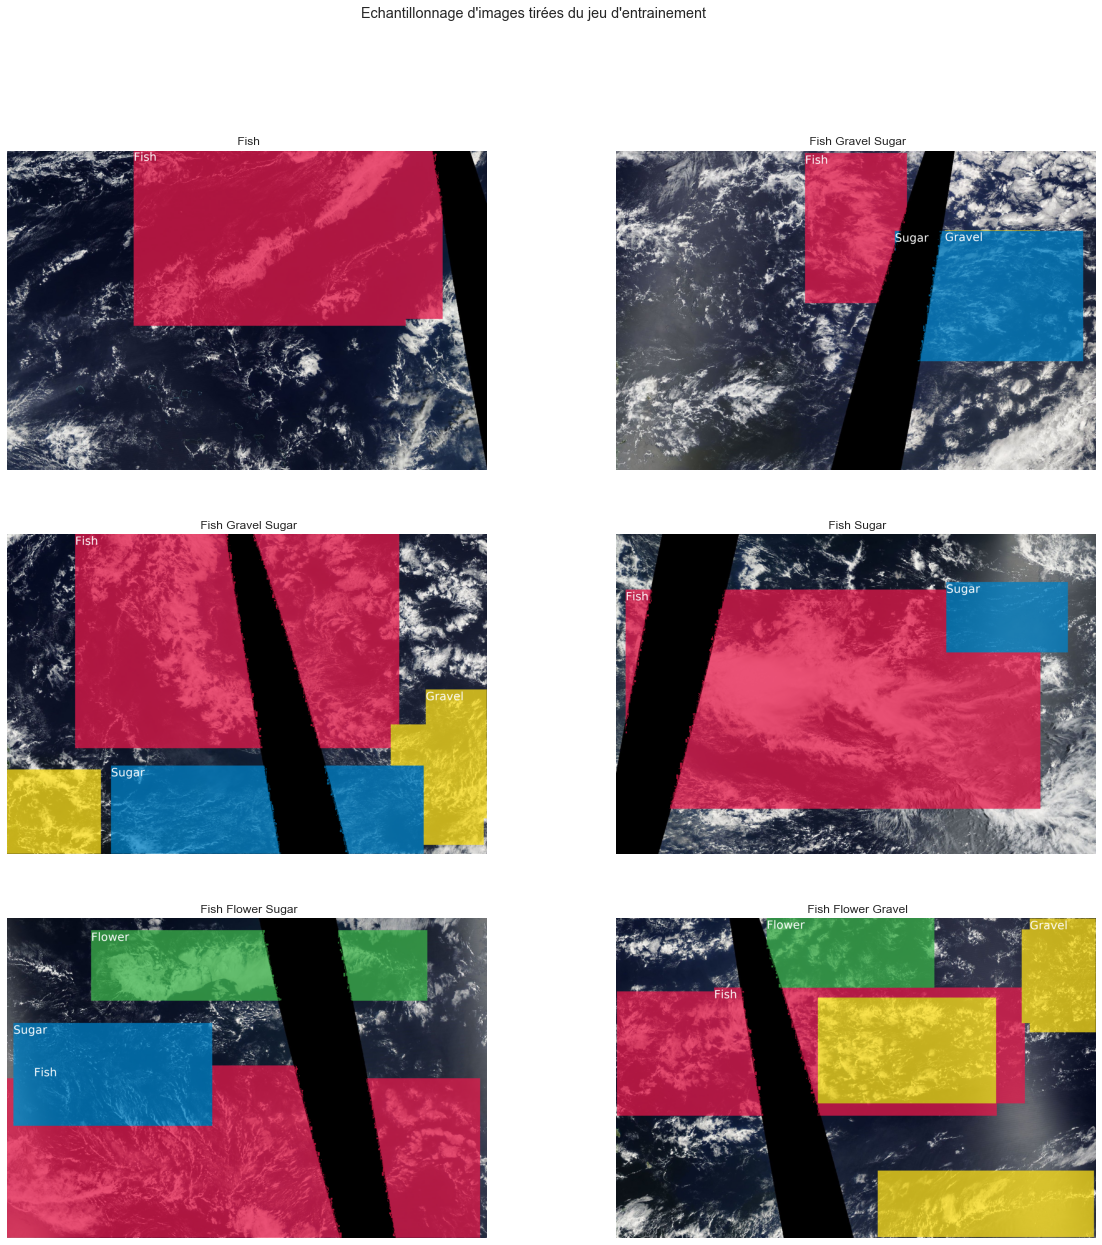

In [167]:
np.random.seed(42)
plot_training_images_and_masks()

Ajout de data augmentation:
A présent nous pouvons facilement ajouter la data augmentation à nos image et les cartes de segmpentation avec imgaug.

No handles with labels found to put in legend.


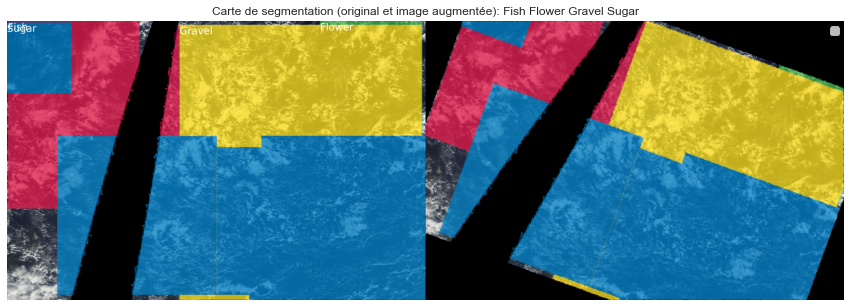

In [170]:
# initialise les augmentations
seq = iaa.Sequential([
    iaa.Affine(rotate=(-30, 30)),
    iaa.Fliplr(0.5),
    iaa.ElasticTransformation(alpha=10, sigma=1)
])

# Sélectionne aléatoirment l'index d'une image
rnd_index = np.random.choice(range(len(train_fns)))
img_id = train_fns[rnd_index]

image = Image.open(img_id)
segmap = create_segmap(img_id)

# Aplique l'augmentation pour l'image et le masque
image_aug, segmap_aug = seq(image=np.asarray(image), segmentation_maps=segmap)

# Visualise l'image et la carte
side_by_side = np.hstack([
    draw_segmentation_maps(img_id),
    np.asarray(segmap_aug.draw_on_image(image_aug)).reshape(np.asarray(image).shape)
])

labels = get_labels(img_id.split(slash)[-1])

fig, ax = plt.subplots(figsize=(15, 7))
ax.axis('off')
plt.title('Carte de segmentation (original et image augmentée):' + labels)
plt.legend()

ax.imshow(side_by_side);